# Understanding Black-Box Chess Agents
This notebook generates saliency maps for a move played by the stockfish engine. The saliency maps give an insight to the tactic behind a particular move.

In [15]:
import chess #version: 0.27.3
import chess.uci
import chess.pgn
import sys
import math
import matplotlib.pyplot as plt
import copy
import cairosvg
import cv2
import time
import numpy as np
import svg_custom.svg_custom as svg_custom # use chess.svg if you don't want the board in B/W

# load your engine:
handler = chess.uci.InfoHandler()
engine = chess.uci.popen_engine('/home/shripad/Desktop/Shripad/Downloaded_Codes/stockfish-saliency/stockfish-10-linux/Linux/stockfish_10_x64') #give path to your engine here
engine.info_handlers.append(handler)
# board


In [16]:
import numpy as np
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon

def your_softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def your_entropy(q_vals):
    entropy_q = [i*math.log(i)/math.log(2) for i in q_vals]
    entropy = sum(entropy_q)*-1
    return entropy

def return_q_vals(board, legal_moves, eval_time=100):
    """
    This function calculates Q-values of every move for the given board.
    Input:
        board: chess.Board()
        legal_moves: List of legal moves of original state
        eval_time: Search time for stockfish
    Output:
        q_vals: np array of Q values of required moves
        max_move: chess.Move() - Best move in perturbed state
        second_max_move: chess.Move() - Second best move in perturbed state
        """
    i = 0
    q_vals = []
    
    maxq = -100000000
    second_maxq = -100000000
    max_move = None
    
    set_current_legal_moves = set(board.legal_moves)
    set_original_legal_moves = set(legal_moves)
    intersection_set = set_current_legal_moves.intersection(set_original_legal_moves)
    second_max_move = None
    
    print('Total Legal Moves : ', len(intersection_set))

    for el in legal_moves:
        if el in intersection_set:
            i += 1
            print(i,'\r',end = '')

            engine.go(searchmoves=[el],movetime=eval_time)
            if handler.info["score"][1].cp is None:
                score = handler.info["score"][1].mate
            else:
                score = round(handler.info["score"][1].cp/100.0,2)
            q_vals.append(score)
            
            if(score > maxq):
                
                second_maxq = maxq
                maxq = score
                
                second_max_move = max_move
                max_move = el
            
            elif(score > second_maxq and score != maxq):
                second_maxq = score
                second_max_move = el

    return np.asarray(q_vals), max_move, second_max_move

def moves_q_vals(board, legal_moves, eval_time, original_move):
    """
    This function returns a dictionary of Q-values for every move.
    Input:
        board: chess.Board()
        legal_moves: List of legal moves of original state
        eval_time: Search time for stockfish
        original_move: original best move (chess.Move()) 
    Output:
        q_vals_dict: Dictionary of move with respective Q-value
        q_vals: np array of Q values of required moves
        max_move: chess.Move() - Best move in perturbed state
        second_max_move: chess.Move() - Second best move in perturbed state
    """
    
    i = 0
    q_vals_dict = {}
    q_vals = []
    
    maxq = -100000000
    second_maxq = -100000000
    max_move = None
    
    set_current_legal_moves = set(board.legal_moves)
    set_original_legal_moves = set(legal_moves)
    intersection_set = set_current_legal_moves.intersection(set_original_legal_moves)
    second_max_move = None
    
    print('Total Legal Moves : ', len(intersection_set))

    for el in legal_moves:
        if el in intersection_set:
            i += 1
            print(i,'\r',end = '')

            engine.go(searchmoves=[el],movetime=eval_time)
#             score = 0.
            if handler.info["score"][1].cp is None:
                score = handler.info["score"][1].mate
            else:
                score = round(handler.info["score"][1].cp/100.0,2)
            if el != original_move:
                q_vals_dict[el.uci()] = score
            q_vals.append(score)
            if(score > maxq):
                
                second_maxq = maxq
                maxq = score
                
                second_max_move = max_move
                max_move = el
            
            elif(score > second_maxq and score != maxq):
                second_maxq = score
                second_max_move = el

    return q_vals_dict, np.asarray(q_vals), max_move, second_max_move


def heat_policy_atari(dictP, dictQ):
    """
    This function calculates L2-norm of 2 policies
    Input:
        dictP: Policy 1 dictionary of moves with Q-values
        dictQ: Policy 2 dictionary of moves with Q-values
    """
    Dpq = 0.
    Q_p = [] #values of moves in dictP^dictQ wrt P
    Q_q = [] #values of moves in dictP^dictQ wrt Q
    dic = dictP.copy()
    dic.update(dictQ)
    for move in dic:
        if move in dictP:
            Q_p.append(dictP[move])
        else:
            Q_p.append(0.)
        if move in dictQ:
            Q_q.append(dictQ[move])
        else:
            Q_q.append(0.)
    # converting Q-values into probability distribution        
    Q_p = your_softmax(np.asarray(Q_p))
    Q_q = your_softmax(np.asarray(Q_q))
    
    S = np.linalg.norm(Q_q - Q_p)

    return S


def cross_entropy(dictP, dictQ):
    """
    This function calculates normalized cross entropy (KL divergence) of Q-values of state Q wrt state P.
    Input:
        dictP: Q-value dictionary of perturbed state
        dictQ: Q-value dictionary of original state
    Output:p = policy[:best_move+1]
    p = np.append(p, policy[best_move+1:])

        K: normalized cross entropy
    """
    Dpq = 0.
    Q_p = [] #values of moves in dictP^dictQ wrt P
    Q_q = [] #values of moves in dictP^dictQ wrt Q
    for move in dictP:
        if move in dictQ:
            Q_p.append(dictP[move])
            Q_q.append(dictQ[move])
    # converting Q-values into probability distribution        
    Q_p = your_softmax(np.asarray(Q_p))
    Q_q = your_softmax(np.asarray(Q_q))
    KL = entropy(Q_q, Q_p)
    return 1./(KL + 1.)


# Generate saliency maps using our cross-entropy method
We took 15 board positions from lichess.com and explained them using saliency maps. These maps are overlaid onto the chess board for ease of interpretation.

You can load your own board positions (fen notation) by changing board_configs.

**Note: <br>
    Change save path of maps <br>
    This code works for board positions where it is white's turn. See stockfish's evaluation documentation to modify it to work correctly for black's turn**

*********************** queen_trap **********************
Total Legal Moves :  44
Original score (Initial probability of best action):  0.9957850671340174
Original value :  5.47
Best Move is  g2g4
Total Legal Moves :  36
Delta P =  0.9207566713697769
KL normalized =  0.31588454746497
Removed R from position: (0, 4)
------------------------------------------
Total Legal Moves :  43
Delta P =  -0.00034208843517868903
KL normalized =  0.8220438722813143
Removed P from position: (1, 2)
------------------------------------------
Total Legal Moves :  37
Delta P =  0.9952943534223168
KL normalized =  0.2643328169324315
Removed Q from position: (1, 3)
------------------------------------------
Total Legal Moves :  43
Delta P =  0.8477557479118634
KL normalized =  0.39296225066918844
Removed P from position: (1, 5)
------------------------------------------
Total Legal Moves :  34
Delta P =  0.17480332386000397
KL normalized =  0.31374127170427485
Removed R from position: (2, 0)
---------------

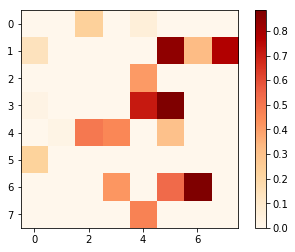

*********************** queen_fork **********************
Total Legal Moves :  49
Original score (Initial probability of best action):  0.8815357465282875
Original value :  4.35
Best Move is  f4b8
Total Legal Moves :  45
Delta P =  0.025247997237319297
KL normalized =  0.8878467503191622
Removed R from position: (0, 0)
------------------------------------------
Total Legal Moves :  46
Delta P =  0.08117693505927914
KL normalized =  0.9102510287183824
Removed R from position: (0, 7)
------------------------------------------
Total Legal Moves :  47
Delta P =  -0.03818614053328373
KL normalized =  0.9882862844688738
Removed P from position: (1, 0)
------------------------------------------
Total Legal Moves :  47
Delta P =  -0.06650842374620591
KL normalized =  0.9698507844662716
Removed P from position: (1, 1)
------------------------------------------
Total Legal Moves :  47
Delta P =  -0.031708139236213295
KL normalized =  0.9699894373111688
Removed P from position: (1, 2)
-----------

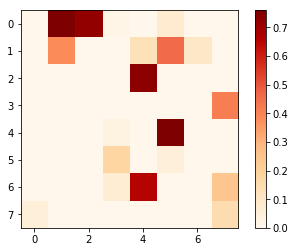

*********************** bishop_takes_rook **********************
Total Legal Moves :  39
Original score (Initial probability of best action):  0.8357190578189241
Original value :  3.35
Best Move is  b2g7
Total Legal Moves :  37
Delta P =  0.6910359971047625
KL normalized =  0.3326947726203634
Removed R from position: (0, 0)
------------------------------------------
Total Legal Moves :  36
Delta P =  -0.0736946584640672
KL normalized =  0.7189653624058446
Removed N from position: (0, 1)
------------------------------------------
Total Legal Moves :  33
Delta P =  -0.10897491670291704
KL normalized =  0.7649882393865458
Removed Q from position: (0, 3)
------------------------------------------
Total Legal Moves :  34
Delta P =  -0.05137831703177975
KL normalized =  0.8632698080637191
Removed B from position: (0, 5)
------------------------------------------
Total Legal Moves :  38
Delta P =  -0.04340800252522836
KL normalized =  0.8625392979051781
Removed R from position: (0, 7)
-------

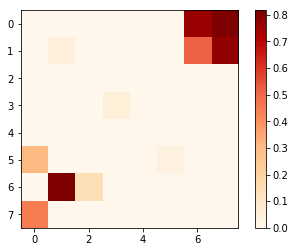

*********************** pawn_takes_bishop **********************
Total Legal Moves :  32
Original score (Initial probability of best action):  0.7656409903686826
Original value :  3.97
Best Move is  f1b1
Total Legal Moves :  30
Delta P =  0.7256879255351588
KL normalized =  0.9745035698896646
Removed P from position: (1, 0)
------------------------------------------
Total Legal Moves :  30
Delta P =  0.23905714847215087
KL normalized =  0.9514654712518358
Removed P from position: (1, 7)
------------------------------------------
Total Legal Moves :  32
Delta P =  0.227292306540141
KL normalized =  0.9646750630973481
Removed P from position: (2, 3)
------------------------------------------
Total Legal Moves :  31
Delta P =  0.23676623422705922
KL normalized =  0.9586707494957503
Removed P from position: (2, 6)
------------------------------------------
Total Legal Moves :  32
Delta P =  0.719165341151752
KL normalized =  0.9047173328403761
Removed b from position: (3, 1)
--------------

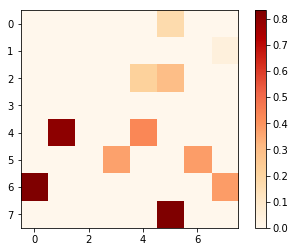

*********************** showdown **********************
Total Legal Moves :  45
Original score (Initial probability of best action):  0.3324512792435686
Original value :  3.0
Best Move is  d4g7
Total Legal Moves :  44
Delta P =  0.0009950282756311934
KL normalized =  0.8815903180402072
Removed R from position: (0, 0)
------------------------------------------
Total Legal Moves :  40
Delta P =  0.2633613938897112
KL normalized =  0.834379245827761
Removed B from position: (0, 2)
------------------------------------------
Total Legal Moves :  43
Delta P =  -0.009009509453382747
KL normalized =  0.8881381847665788
Removed R from position: (0, 5)
------------------------------------------
Total Legal Moves :  43
Delta P =  0.048048396269171234
KL normalized =  0.9480028320531149
Removed P from position: (1, 0)
------------------------------------------
Total Legal Moves :  43
Delta P =  -0.0821597712320229
KL normalized =  0.9031334265896048
Removed P from position: (1, 1)
----------------

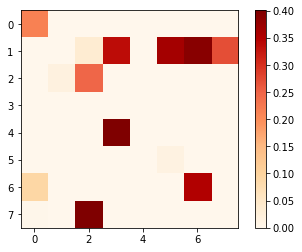

*********************** rook_captures_queen **********************
Total Legal Moves :  34
Original score (Initial probability of best action):  0.9350308370158195
Original value :  4.44
Best Move is  b4d4
Total Legal Moves :  31
Delta P =  0.40024570010385874
KL normalized =  0.1960243028307739
Removed R from position: (0, 2)
------------------------------------------
Total Legal Moves :  28
Delta P =  -0.058586423507287044
KL normalized =  0.24754573909764865
Removed B from position: (0, 3)
------------------------------------------
Total Legal Moves :  33
Delta P =  -0.00015012212995868524
KL normalized =  0.6191735547461568
Removed P from position: (1, 1)
------------------------------------------
Total Legal Moves :  32
Delta P =  0.04881892081263017
KL normalized =  0.7563398726467958
Removed P from position: (1, 6)
------------------------------------------
Total Legal Moves :  32
Delta P =  0.03642200138862017
KL normalized =  0.883862018915946
Removed P from position: (1, 7)
-

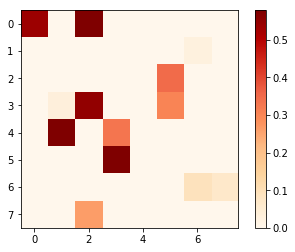

*********************** knight_captures_queen **********************
Total Legal Moves :  39
Original score (Initial probability of best action):  0.9971575905036147
Original value :  6.18
Best Move is  a4e4
Total Legal Moves :  34
Delta P =  0.997083199024297
KL normalized =  0.19239856733929636
Removed R from position: (0, 7)
------------------------------------------
Total Legal Moves :  39
Delta P =  0.89673761302747
KL normalized =  0.7051166198798855
Removed P from position: (1, 2)
------------------------------------------
Total Legal Moves :  37
Delta P =  -0.002074806233789417
KL normalized =  0.92438291914019
Removed P from position: (1, 7)
------------------------------------------
Total Legal Moves :  39
Delta P =  0.010205954317771049
KL normalized =  0.903691042576077
Removed P from position: (2, 0)
------------------------------------------
Total Legal Moves :  33
Delta P =  0.9917192132336213
KL normalized =  0.16438608988082254
Removed N from position: (2, 2)
---------

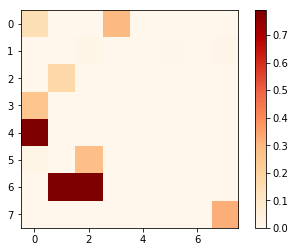

*********************** rook_up **********************
Total Legal Moves :  40
Original score (Initial probability of best action):  0.9551887273854418
Original value :  5.56
Best Move is  f3e3
Total Legal Moves :  38
Delta P =  -0.017576925065937443
KL normalized =  0.19543444358065218
Removed P from position: (1, 6)
------------------------------------------
Total Legal Moves :  24
Delta P =  0.9137088507987994
KL normalized =  0.1230540341316634
Removed Q from position: (2, 1)
------------------------------------------
Total Legal Moves :  39
Delta P =  -0.001281616524243967
KL normalized =  0.15796329161929623
Removed P from position: (2, 7)
------------------------------------------
Total Legal Moves :  40
Delta P =  -0.044811272614558195
KL normalized =  0.7241220281538392
Removed r from position: (3, 3)
------------------------------------------
Total Legal Moves :  40
Delta P =  -0.011367153866700508
KL normalized =  0.9456356045331787
Removed p from position: (5, 5)
----------

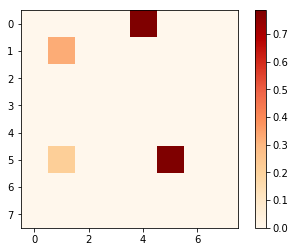

*********************** queen_exchange **********************
Total Legal Moves :  32
Original score (Initial probability of best action):  0.989875879200879
Original value :  4.28
Best Move is  g3g4
Total Legal Moves :  30
Delta P =  -0.0022325658883536326
KL normalized =  0.9581847539084496
Removed R from position: (0, 0)
------------------------------------------
Total Legal Moves :  28
Delta P =  0.055818536596905166
KL normalized =  0.9468416194015594
Removed R from position: (0, 2)
------------------------------------------
Total Legal Moves :  30
Delta P =  0.12047403622151209
KL normalized =  0.9597703025108991
Removed P from position: (1, 2)
------------------------------------------
Total Legal Moves :  31
Delta P =  0.12790877012932378
KL normalized =  0.40100469465739164
Removed N from position: (1, 4)
------------------------------------------
Total Legal Moves :  25
Delta P =  0.04744435870829933
KL normalized =  0.9967753573137157
Removed P from position: (1, 5)
--------

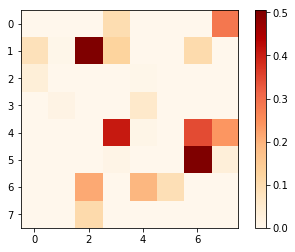

*********************** discover_attack **********************
Total Legal Moves :  29
Original score (Initial probability of best action):  0.9950188057012459
Original value :  6.27
Best Move is  c2b2
Total Legal Moves :  11
Delta P =  0.9950187612534395
KL normalized =  0.8951337391104874
Removed Q from position: (0, 6)
------------------------------------------
Total Legal Moves :  26
Delta P =  0.7206441679822833
KL normalized =  0.41458387184639456
Removed N from position: (1, 4)
------------------------------------------
Total Legal Moves :  27
Delta P =  0.0071692247801292686
KL normalized =  0.7347504844114683
Removed P from position: (1, 7)
------------------------------------------
Total Legal Moves :  29
Delta P =  0.06729357698933291
KL normalized =  0.1904035428812272
Removed q from position: (2, 0)
------------------------------------------
Total Legal Moves :  28
Delta P =  0.9461170312106472
KL normalized =  0.7234679952481496
Removed P from position: (2, 2)
-----------

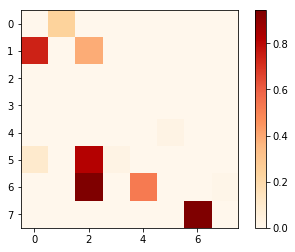

*********************** standoff **********************
Total Legal Moves :  38
Original score (Initial probability of best action):  0.9787378733929003
Original value :  5.29
Best Move is  d2f4
Total Legal Moves :  31
Delta P =  0.9759578195407412
KL normalized =  0.16367354802541498
Removed R from position: (0, 7)
------------------------------------------
Total Legal Moves :  34
Delta P =  0.6786797767358338
KL normalized =  0.40878845831293775
Removed N from position: (1, 5)
------------------------------------------
Total Legal Moves :  36
Delta P =  0.2002568098958245
KL normalized =  0.8250995817847685
Removed P from position: (1, 6)
------------------------------------------
Total Legal Moves :  38
Delta P =  0.10752756555535392
KL normalized =  0.13377970385539584
Removed q from position: (2, 0)
------------------------------------------
Total Legal Moves :  37
Delta P =  -0.021260391354681274
KL normalized =  0.20445913484719153
Removed b from position: (2, 1)
---------------

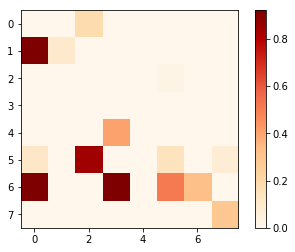

*********************** rook_takes_bishop **********************
Total Legal Moves :  39
Original score (Initial probability of best action):  0.7492466414366538
Original value :  4.87
Best Move is  d2d7
Total Legal Moves :  34
Delta P =  0.7491434379587992
KL normalized =  0.7634518813421934
Removed R from position: (0, 3)
------------------------------------------
Total Legal Moves :  37
Delta P =  -0.022019437412558296
KL normalized =  0.9079254380130686
Removed P from position: (1, 0)
------------------------------------------
Total Legal Moves :  37
Delta P =  0.6974108201467935
KL normalized =  0.7513555235467554
Removed P from position: (1, 1)
------------------------------------------
Total Legal Moves :  39
Delta P =  -0.0373501939359252
KL normalized =  0.9221294379996721
Removed P from position: (1, 2)
------------------------------------------
Total Legal Moves :  35
Delta P =  0.20887056848462482
KL normalized =  0.9581728401102005
Removed Q from position: (1, 5)
---------

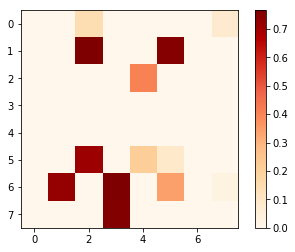

*********************** bishop_takes_queen **********************
Total Legal Moves :  39
Original score (Initial probability of best action):  0.9937365402270024
Original value :  4.47
Best Move is  e1e5
Total Legal Moves :  35
Delta P =  0.9936881063394437
KL normalized =  0.0514271724655312
Removed R from position: (0, 3)
------------------------------------------
Total Legal Moves :  37
Delta P =  0.0024124121829655065
KL normalized =  0.9908510870332645
Removed P from position: (1, 0)
------------------------------------------
Total Legal Moves :  37
Delta P =  0.0035839553098548915
KL normalized =  0.990730213013921
Removed P from position: (1, 1)
------------------------------------------
Total Legal Moves :  37
Delta P =  0.6689565308765026
KL normalized =  0.9674958782395928
Removed P from position: (1, 5)
------------------------------------------
Total Legal Moves :  37
Delta P =  -0.003148263012564989
KL normalized =  0.9719057274050369
Removed P from position: (1, 6)
-----

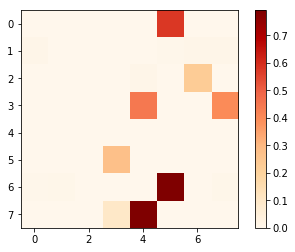

*********************** bishop_up **********************
Total Legal Moves :  41
Original score (Initial probability of best action):  0.900640489867703
Original value :  5.48
Best Move is  e4c5
Total Legal Moves :  40
Delta P =  0.0444750076808933
KL normalized =  0.9418387209307068
Removed R from position: (0, 0)
------------------------------------------
Total Legal Moves :  39
Delta P =  0.015293129087794677
KL normalized =  0.9557563172390536
Removed B from position: (0, 2)
------------------------------------------
Total Legal Moves :  37
Delta P =  0.06188970622383494
KL normalized =  0.9458328085542581
Removed R from position: (0, 5)
------------------------------------------
Total Legal Moves :  39
Delta P =  0.003631170759165747
KL normalized =  0.9390703300930444
Removed P from position: (1, 0)
------------------------------------------
Total Legal Moves :  39
Delta P =  0.10000973922383782
KL normalized =  0.9310877342062228
Removed P from position: (1, 1)
-----------------

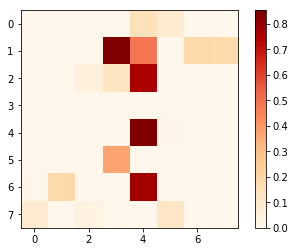

*********************** bishop_fork **********************
Total Legal Moves :  43
Original score (Initial probability of best action):  0.9973951139087857
Original value :  5.16
Best Move is  c5b6
Total Legal Moves :  38
Delta P =  0.004742374206390454
KL normalized =  0.9441554441656174
Removed R from position: (0, 2)
------------------------------------------
Total Legal Moves :  33
Delta P =  0.024667005258915742
KL normalized =  0.48972784862192986
Removed Q from position: (0, 3)
------------------------------------------
Total Legal Moves :  42
Delta P =  0.002961294043124396
KL normalized =  0.9716693017055721
Removed R from position: (0, 5)
------------------------------------------
Total Legal Moves :  42
Delta P =  -0.0004948102611569416
KL normalized =  0.9554238453954311
Removed P from position: (1, 0)
------------------------------------------
Total Legal Moves :  39
Delta P =  0.0009603329766023627
KL normalized =  0.8408531051547748
Removed B from position: (1, 4)
------

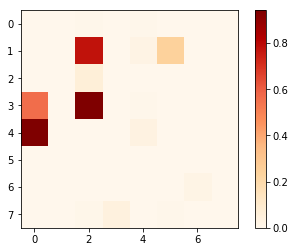

In [17]:
######################## heatmaps for cross entropy method
    
board_configs = {}
board_configs['queen_trap'] = '2r1r1k1/b4ppp/p3p3/Pp2Nq2/1Pbp1B2/R7/2PQ1PP1/4R1K1 w - - 0 1'
board_configs['queen_fork'] = 'rnbq1rk1/pp2bppp/4p3/3p3n/3P1B2/3B1N2/PPPNQPPP/R3K2R w KQkq - 0 1'
board_configs['bishop_takes_rook'] = 'rnbqk1nr/1p3ppp/4p3/2bp4/8/p3PN2/1BP2PPP/RN1QKB1R w - - 0 1'
board_configs['pawn_takes_bishop'] = '1k3r2/p6p/2p1Bp2/4p3/1b1pP3/3P2P1/P1K4P/5R2 w - - 0 1'
board_configs['showdown'] = 'rn1qk1nr/p1pp1ppp/1pb1p3/8/2BQ4/2P2N2/PPP2PPP/R1B2RK1 w - - 0 1'
board_configs['rook_captures_queen'] = 'r1r5/2k3pp/2p2p2/1pR1pq2/PQ1n4/3P4/1P4PP/1KRB4 w - - 0 1'
board_configs['knight_captures_queen'] = 'r2r4/1kp2p1p/1q2b1p1/R7/Q7/P1N5/1PP4P/1K5R w - - 0 1'
board_configs['rook_up'] = '4r1k1/1R4p1/4qp1p/8/3r4/1Q3R1P/6P1/7K w - - 0 1'
board_configs['queen_exchange'] = '2kr3r/bbqp1pp1/p3p3/1p2n3/1P1NPBnp/P2B2QP/2P1NPP1/R1R3K1 w - - 0 1'
board_configs['discover_attack'] = '1r6/pkp2p1p/5b2/5p2/5P2/q1PP4/2R1N2P/1K4Q1 w - - 0 1'
board_configs['standoff'] = '1kr5/pr4p1/5n1p/5p2/3P4/qbR2P1P/B2Q1NP1/K6R w - - 0 1'
board_configs['rook_takes_bishop'] = '1kr2b1r/1pq2bpp/p3np2/2p1p3/4P3/2N1BPN1/PPPR1QPP/1K1R4 w - - 0 1'
board_configs['bishop_takes_queen'] = '5rk1/p1q2ppp/1p2p1n1/2p1r2Q/2P5/3B4/PP3PPP/3RR1K1 w - - 0 1'
board_configs['bishop_up'] = '4rrk1/pp1qp1bp/2pnbpp1/8/3PNP2/2PB4/PP2Q1PP/R1B2RK1 w - - 0 1'
board_configs['bishop_fork'] = '2b1r1k1/2q1bppp/2p3n1/r1B1p3/N3n3/5N2/P3BPPP/2RQ1RK1 w - - 0 1'

for board_name in board_configs:
    print("***********************", board_name, "**********************")
    time.sleep(1)
    board = chess.Board(board_configs[board_name])
    evaltime = 100
    
    # set original state 
    engine.position(board)
    evaluation = engine.go(movetime=evaltime)
    original_move = evaluation.bestmove

    legal_moves = list(board.legal_moves)[:]

    
    # Q-values for original state
    q_vals_dict_og, q_vals, _,second_best_move  = moves_q_vals(board, legal_moves, evaltime, original_move)

    q_old = np.max(q_vals)

    
    # probability of original_move in original state
    old_score = np.exp(max(q_vals))/np.sum(np.exp(q_vals))

    # policy of original state
#     softmax = your_softmax(q_vals)
#     entropy_og = entropy(softmax)

    print("Original score (Initial probability of best action): ", old_score)
    print("Original value : ", max(q_vals))
    print("Best Move is ", original_move)
    heatmap = np.zeros((8, 8))
#     entropy_map = np.zeros((8,8))

    for i in range(64):
        h = i//8 
        w = i%8
        
        # perturb board
        piece_removed = board.remove_piece_at(i)

        # Evaluate the board on the basis of the value
        if piece_removed is not None:

            # If king is removed or if board position is illegal set it back 
            if (piece_removed == chess.Piece(6,True) or piece_removed == chess.Piece(6,False)) or board.was_into_check():
                board.set_piece_at(i, piece_removed)
            else:
                # set perturbed state
                engine.position(board)

                # Check if the original move is still valid
                if board.is_legal(original_move):

                    # Find the index of the original move in the list of legal moves
                    j = 0
                    original_move_index = 0
                    for el in legal_moves:
                        if el in board.legal_moves:
                            if(el == original_move):
                                original_move_index = j
                            j+=1

                    # Find the q values 
                    q_vals_dict_new, q_vals, new_best_move, new_second_best_move = moves_q_vals(board, legal_moves, evaltime, original_move)

                    # probability of original move in perturbed state
                    new_score = np.exp(q_vals[original_move_index])/np.sum(np.exp(q_vals))

                    new_q = q_vals[original_move_index]

                    K = cross_entropy(q_vals_dict_new, q_vals_dict_og)

                    dP = old_score - new_score

                    if new_score < old_score: # harmonic mean
                        heatmap[h, w] = 2*dP*K/(dP + K)
                    else:
                        heatmap[h, w] = 0.

                    print("Delta P = ", dP)
                    print("KL normalized = ", K)
                    print('Removed', piece_removed, 'from position:', (h, w))
                    print('------------------------------------------')
                
                else:
                    # illegal original move in perturbed state
                    heatmap[h, w] = -1.

                # undo perturbation
                board.set_piece_at(i, piece_removed)

    heatmap = np.flipud(heatmap)
    
    
    # If original move is not valid, give highest value in the heat map
    heatmap[heatmap == -1] = np.max(heatmap)
    
    
    
    ### Original Saliency Map (without overlay onto board)
    
    plt.figure(1)
    plt.imshow(heatmap, cmap='OrRd')
    plt.colorbar()
    plt.savefig('results/entropy/map_'+board_name+'.png')
    plt.show()    


    #### Saliency map overlaid on board
    
    svg = svg_custom.board(board) 
    with open('board.svg', 'w+') as f:
        f.write(svg)
    cairosvg.svg2png(url='board.svg', write_to='board.png')

    # original board as a numpy array
    board_array = cv2.imread('board.png')
    
    threshold = (80/256)*np.max(heatmap) # percentage threshold. Saliency values above this threshold won't be mapped onto board

    # Create bounding boxes with saliency colours for every square on chess board
    for i in range(0, 8, 1):
        for j in range(0, 8, 1):
            ii = 45*i+20
            jj = 45*j+20
            value_of_square =  heatmap[i, j]
            if value_of_square < threshold:
                continue
            for box_i in range(ii, ii+44, 1):
                for box_j in range(jj, jj+44, 1):
                    if box_i > ii+4 and box_i < ii+40 and box_j > jj+4 and box_j < jj+40:
                        continue
                    board_array[box_i, box_j, 0] = 256 - 0.8*256*heatmap[i, j]/(np.max(heatmap))
                    board_array[box_i, box_j, 1] = 256 - 0.84*256*heatmap[i, j]/(np.max(heatmap))
                    board_array[box_i, box_j, 2] = 256 - 0.19*256*heatmap[i, j]/(np.max(heatmap))
    
    cv2.imwrite("results/entropy/" + board_name + ".png",board_array)


# Generate Saliency Maps using other methods


*************************queen_trap*****************************
Original value :  5.53
-----------------------------
Position :  0 2
Piece :  r
New Action Value :  12.93
New State Value :  12.92
-----------------------------
Position :  0 4
Piece :  r
New Action Value :  10.75
New State Value :  11.01
-----------------------------
Position :  1 0
Piece :  b
New Action Value :  9.63
New State Value :  9.7
-----------------------------
Position :  1 5
Piece :  p
New Action Value :  -0.18
New State Value :  0.85
-----------------------------
Position :  1 6
Piece :  p
New Action Value :  8.4
New State Value :  10.12
-----------------------------
Position :  1 7
Piece :  p
New Action Value :  -2.14
New State Value :  1.71
-----------------------------
Position :  2 0
Piece :  p
New Action Value :  7.38
New State Value :  7.56
-----------------------------
Position :  2 4
Piece :  p
New Action Value :  -2.04
New State Value :  -0.79
-----------------------------
Position :  3 0
Piece :  P


New Action Value :  11.66
New State Value :  12.0
-----------------------------
Position :  1 0
Piece :  p
New Action Value :  5.36
New State Value :  5.57
-----------------------------
Position :  1 7
Piece :  p
New Action Value :  5.32
New State Value :  5.56
-----------------------------
Position :  2 2
Piece :  p
New Action Value :  5.42
New State Value :  5.86
-----------------------------
Position :  2 4
Piece :  B
New Action Value :  -2.15
New State Value :  -2.06
-----------------------------
Position :  2 5
Piece :  p
New Action Value :  -0.06
New State Value :  0.72
-----------------------------
Position :  3 4
Piece :  p
New Action Value :  5.91
New State Value :  6.02
-----------------------------
Position :  4 1
Piece :  b
New Action Value :  5.19
New State Value :  5.4
-----------------------------
Position :  4 3
Piece :  p
New Action Value :  5.41
New State Value :  5.58
-----------------------------
Position :  4 4
Piece :  P
New Action Value :  2.02
New State Value : 

New Action Value :  6.69
New State Value :  6.87
-----------------------------
Position :  4 3
Piece :  r
New Action Value :  56.85
New State Value :  62.95
-----------------------------
Position :  5 1
Piece :  Q
New Action Value :  -5
New State Value :  -15.29
-----------------------------
Position :  5 7
Piece :  P
New Action Value :  3.96
New State Value :  3.98
-----------------------------
Position :  6 6
Piece :  P
New Action Value :  3.72
New State Value :  3.55
*************************queen_exchange*****************************
Original value :  3.93
-----------------------------
Position :  0 3
Piece :  r
New Action Value :  10.27
New State Value :  10.56
-----------------------------
Position :  0 7
Piece :  r
New Action Value :  11.26
New State Value :  11.28
-----------------------------
Position :  1 0
Piece :  b
New Action Value :  9.62
New State Value :  9.56
-----------------------------
Position :  1 1
Piece :  b
New Action Value :  10.06
New State Value :  10.12
---

New Action Value :  7.64
New State Value :  7.83
-----------------------------
Position :  4 4
Piece :  P
New Action Value :  2.28
New State Value :  2.4
-----------------------------
Position :  5 2
Piece :  N
New Action Value :  -4.6
New State Value :  -4.59
-----------------------------
Position :  5 4
Piece :  B
New Action Value :  -1.25
New State Value :  -1.19
-----------------------------
Position :  5 5
Piece :  P
New Action Value :  2.95
New State Value :  3.42
-----------------------------
Position :  5 6
Piece :  N
New Action Value :  -0.72
New State Value :  -0.75
-----------------------------
Position :  6 0
Piece :  P
New Action Value :  3.23
New State Value :  3.17
-----------------------------
Position :  6 1
Piece :  P
New Action Value :  -2.78
New State Value :  -1.58
-----------------------------
Position :  6 2
Piece :  P
New Action Value :  2.62
New State Value :  2.94
-----------------------------
Position :  6 5
Piece :  Q
New Action Value :  -9.95
New State Valu

New Action Value :  0.0
New State Value :  -0.25
-----------------------------
Position :  6 7
Piece :  P
New Action Value :  3.68
New State Value :  3.87
-----------------------------
Position :  7 2
Piece :  R
New Action Value :  -2.42
New State Value :  -2.5
-----------------------------
Position :  7 3
Piece :  Q
New Action Value :  -11.81
New State Value :  -11.59
-----------------------------
Position :  7 5
Piece :  R
New Action Value :  -2.24
New State Value :  -1.75


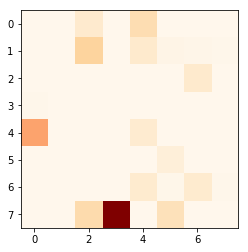

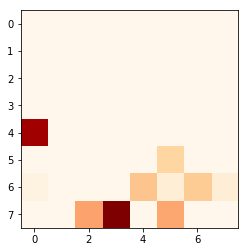

In [18]:
######################## heatmaps for other comparison methods

for board_name in board_configs:
    print("*************************" + board_name + "*****************************")
    time.sleep(1)
    board = chess.Board(board_configs[board_name])
    handler = chess.uci.InfoHandler()
    engine = chess.uci.popen_engine('/home/shripad/Desktop/Shripad/Downloaded_Codes/stockfish-saliency/stockfish-10-linux/Linux/stockfish_10_x64') #give path to your engine here
    engine.info_handlers.append(handler)
    
    engine.position(board)
    evaltime = 100 
    best_evaluation = engine.go(movetime=evaltime)
    
    # V of original state (This is also Q(original state, best action))
    V = handler.info["score"][1].cp/100.0
    move_to_take = [best_evaluation[0]]
    print("Original value : ", V)
    
    # V-based method
    heatmap = np.zeros((8,8))
    # Q-based method
    heatmapQ = np.zeros((8,8))
    
    for i in range(8):
        for j in range(8):
            pos = 8*(7-i) + j
            #perturb board
            piece = board.remove_piece_at(pos)
            
            if piece is None or piece.piece_type is 6 or board.was_into_check() or board.is_legal(move_to_take[0]) is False:
                heatmap[i][j] = 0.
                heatmapQ[i, j] = 0.
            else:
                print("-----------------------------")
                print("Position : ", i, j)
                print("Piece : ", piece)
                
                engine.position(board)
                p_evaluation = engine.go(searchmoves=move_to_take, movetime=evaltime)
                # Q for original move in perturbed state
                if handler.info["score"][1].cp is None:
                    p_Q = handler.info["score"][1].mate
                else:
                    p_Q = handler.info["score"][1].cp/100.0
                
                
                engine.position(board)
                p_evaluation = engine.go(movetime=evaltime)
                # V of perturbed_state
                if handler.info["score"][1].cp is None:
                    p_V = handler.info["score"][1].mate
                else:
                    p_V = handler.info["score"][1].cp/100.0
                print("New Action Value : ", p_Q)
                print("New State Value : ", p_V)
                heatmap[i][j] = pow(V - p_V,2)*0.5
                heatmapQ[i, j] = max(V - p_Q, 0)
                
            board.set_piece_at(pos, piece)
    
    
    
##### Original Saliency maps
    
    plt.figure(1)
    plt.imshow(heatmap, cmap='OrRd')
    plt.savefig('results/value_l2/V_map_' + board_name + '.png')
    
    plt.figure(2)
    plt.imshow(heatmapQ, cmap='OrRd')
    plt.savefig('results/action_value/Q_map_' + board_name + '.png')
    
    
##### Saliency maps on the chess board    
    
    ########## Saving 0.5*(V1 - V2)**2
    svg = svg_custom.board(board)
    with open('board.svg', 'w+') as f:
        f.write(svg)
    cairosvg.svg2png(url='board.svg', write_to='board.png')
    board_array = cv2.imread('board.png')

    threshold = (80/256)*np.max(heatmap) # percentage threshold. Saliency values above this threshold won't be mapped onto board
    
    # Create bounding boxes with saliency colours for every square on chess board
    for i in range(0, 8, 1):
        for j in range(0, 8, 1):
            ii = 45*i+20
            jj = 45*j+20
            value_of_square =  heatmap[i, j]
            if value_of_square < threshold:
                continue
            for box_i in range(ii, ii+44, 1):
                for box_j in range(jj, jj+44, 1):
                    if box_i > ii+4 and box_i < ii+40 and box_j > jj+4 and box_j < jj+40:
                        continue
                    board_array[box_i, box_j, 0] = 256 - 0.8*256*heatmap[i, j]/(np.max(heatmap))
                    board_array[box_i, box_j, 1] = 256 - 0.84*256*heatmap[i, j]/(np.max(heatmap))
                    board_array[box_i, box_j, 2] = 256 - 0.19*256*heatmap[i, j]/(np.max(heatmap))
    
    cv2.imwrite("results/value_l2/V_" + board_name + ".png" ,board_array)
    
    ############# Saving Q2 - Q1
        
    svg = svg_custom.board(board)
    with open('board.svg', 'w+') as f:
        f.write(svg)
    cairosvg.svg2png(url='board.svg', write_to='board.png')
    board_array = cv2.imread('board.png')

    threshold = (80/256)*np.max(heatmapQ) # percentage threshold. Saliency values above this threshold won't be mapped onto board

    # Create bounding boxes with saliency colours for every square on chess board
    for i in range(0, 8, 1):
        for j in range(0, 8, 1):
            ii = 45*i+20
            jj = 45*j+20
            value_of_square =  heatmapQ[i, j]
            if value_of_square < threshold:
                continue
            for box_i in range(ii, ii+44, 1):
                for box_j in range(jj, jj+44, 1):
                    if box_i > ii+4 and box_i < ii+40 and box_j > jj+4 and box_j < jj+40:
                        continue
                    board_array[box_i, box_j, 0] = 256 - 0.8*256*heatmapQ[i, j]/(np.max(heatmapQ))
                    board_array[box_i, box_j, 1] = 256 - 0.84*256*heatmapQ[i, j]/(np.max(heatmapQ))
                    board_array[box_i, box_j, 2] = 256 - 0.19*256*heatmapQ[i, j]/(np.max(heatmapQ))
    
    cv2.imwrite("results/action_value/Q_" + board_name + ".png" ,board_array)

    
    

*********************** queen_trap **********************
Total Legal Moves :  44
Total Legal Moves :  44
Total Legal Moves :  44
Total Legal Moves :  44
Total Legal Moves :  44
Total Legal Moves :  44
Total Legal Moves :  44
Total Legal Moves :  44
Total Legal Moves :  44
Total Legal Moves :  44
Total Legal Moves :  44
Total Legal Moves :  36
Total Legal Moves :  44
Total Legal Moves :  44
Total Legal Moves :  44
Total Legal Moves :  43
Total Legal Moves :  39
Total Legal Moves :  34
Total Legal Moves :  43
Total Legal Moves :  37
Total Legal Moves :  43
Total Legal Moves :  36
*********************** queen_fork **********************
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves :  49
Total Legal Moves : 

Total Legal Moves :  43
Total Legal Moves :  43
Total Legal Moves :  40
Total Legal Moves :  43
Total Legal Moves :  37
Total Legal Moves :  42
Total Legal Moves :  39
Total Legal Moves :  43
Total Legal Moves :  41
Total Legal Moves :  41
Total Legal Moves :  38
Total Legal Moves :  33
Total Legal Moves :  42


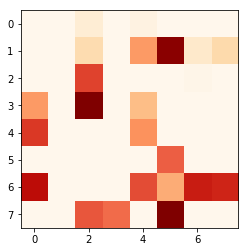

In [19]:
def heat(dictP, dictQ):
    Dpq = 0.
    Q_p = [] #values of moves in dictP^dictQ wrt P
    Q_q = [] #values of moves in dictP^dictQ wrt Q
    dic = dictP.copy()
    dic.update(dictQ)
    for move in dic:
        if move in dictP:
            Q_p.append(dictP[move])
        else:
            Q_p.append(0.)
        if move in dictQ:
            Q_q.append(dictQ[move])
        else:
            Q_q.append(0.)
    # converting Q-values into probability distribution        
    Q_p = your_softmax(np.asarray(Q_p))
    Q_q = your_softmax(np.asarray(Q_q))
    
    S = np.linalg.norm(Q_q - Q_p)

    return S

board_configs = {}
board_configs['queen_trap'] = '2r1r1k1/b4ppp/p3p3/Pp2Nq2/1Pbp1B2/R7/2PQ1PP1/4R1K1 w - - 0 1'
board_configs['queen_fork'] = 'rnbq1rk1/pp2bppp/4p3/3p3n/3P1B2/3B1N2/PPPNQPPP/R3K2R w KQkq - 0 1'
board_configs['bishop_takes_rook'] = 'rnbqk1nr/1p3ppp/4p3/2bp4/8/p3PN2/1BP2PPP/RN1QKB1R w - - 0 1'
board_configs['pawn_takes_bishop'] = '1k3r2/p6p/2p1Bp2/4p3/1b1pP3/3P2P1/P1K4P/5R2 w - - 0 1'
board_configs['showdown'] = 'rn1qk1nr/p1pp1ppp/1pb1p3/8/2BQ4/2P2N2/PPP2PPP/R1B2RK1 w - - 0 1'
board_configs['rook_captures_queen'] = 'r1r5/2k3pp/2p2p2/1pR1pq2/PQ1n4/3P4/1P4PP/1KRB4 w - - 0 1'
board_configs['knight_captures_queen'] = 'r2r4/1kp2p1p/1q2b1p1/R7/Q7/P1N5/1PP4P/1K5R w - - 0 1'
board_configs['rook_up'] = '4r1k1/1R4p1/4qp1p/8/3r4/1Q3R1P/6P1/7K w - - 0 1'
board_configs['queen_exchange'] = '2kr3r/bbqp1pp1/p3p3/1p2n3/1P1NPBnp/P2B2QP/2P1NPP1/R1R3K1 w - - 0 1'
board_configs['discover_attack'] = '1r6/pkp2p1p/5b2/5p2/5P2/q1PP4/2R1N2P/1K4Q1 w - - 0 1'
board_configs['standoff'] = '1kr5/pr4p1/5n1p/5p2/3P4/qbR2P1P/B2Q1NP1/K6R w - - 0 1'
board_configs['rook_takes_bishop'] = '1kr2b1r/1pq2bpp/p3np2/2p1p3/4P3/2N1BPN1/PPPR1QPP/1K1R4 w - - 0 1'
board_configs['bishop_takes_queen'] = '5rk1/p1q2ppp/1p2p1n1/2p1r2Q/2P5/3B4/PP3PPP/3RR1K1 w - - 0 1'
board_configs['bishop_up'] = '4rrk1/pp1qp1bp/2pnbpp1/8/3PNP2/2PB4/PP2Q1PP/R1B2RK1 w - - 0 1'
board_configs['bishop_fork'] = '2b1r1k1/2q1bppp/2p3n1/r1B1p3/N3n3/5N2/P3BPPP/2RQ1RK1 w - - 0 1'

for board_name in board_configs:
    print("***********************", board_name, "**********************")
    time.sleep(1)
    board = chess.Board(board_configs[board_name])
    evaltime = 100
    
    # set original state 
    engine.position(board)
    evaluation = engine.go(movetime=evaltime)
    original_move = evaluation.bestmove

    legal_moves = list(board.legal_moves)[:]

    
    # Q-values for original state
    q_vals_dict_og, q_vals, _,second_best_move  = moves_q_vals(board, legal_moves, evaltime, original_move)

    old_V = np.max(q_vals)

    
    # probability of original_move in original state
    old_score = np.exp(max(q_vals))/np.sum(np.exp(q_vals))

    heatmapV = np.zeros((8, 8))
    heatmapP = np.zeros((8, 8))

    for h in range(8):
        for w in range(8):
        # perturb board
            pos = 8*(7-h) + w
            piece_removed = board.remove_piece_at(pos)

            # Evaluate the board on the basis of the value
            if piece_removed is not None:

                # If king is removed or if board position is illegal set it back 
                if (piece_removed == chess.Piece(6,True) or piece_removed == chess.Piece(6,False)) or board.was_into_check():
                    board.set_piece_at(pos, piece_removed)
                else:
                    # set perturbed state
                    engine.position(board)

                    # Check if the original move is still valid
                    if board.is_legal(original_move):

                        # Find the index of the original move in the list of legal moves
                        j = 0
                        original_move_index = 0
                        for el in legal_moves:
                            if el in board.legal_moves:
                                if(el == original_move):
                                    original_move_index = j
                                j+=1

                        # Find the q values 
                        q_vals_dict_new, q_vals, new_best_move, new_second_best_move = moves_q_vals(board, legal_moves, evaltime, original_move)

                        # probability of original move in perturbed state
                        new_score = np.exp(q_vals[original_move_index])/np.sum(np.exp(q_vals))

                        new_q = q_vals[original_move_index]
                         
                        new_V = np.max(np.asarray(q_vals))

                        K = heat(q_vals_dict_new, q_vals_dict_og)
                        heatmapV[h,w] = 0.5*(old_V - new_V)**2
                        heatmapP[h, w] = K

                    else:
                        # illegal original move in perturbed state
                        heatmapP[h, w] = -1.
                        heatmapV[h, w] = -1
                    # undo perturbation
                    board.set_piece_at(pos, piece_removed)


    # If original move is not valid, give highest value in the heat map
    heatmapV[heatmapV == -1] = np.max(heatmapV)
    heatmapP[heatmapP == -1] = np.max(heatmapP)

#     heatmap = np.zeros((8,8,3))
#     heatmapV = (heatmapV - np.min(heatmapV))/(np.max(heatmapV) - np.min(heatmapV))
#     heatmapP = (heatmapP - np.min(heatmapP))/(np.max(heatmapP) - np.min(heatmapP))
#     heatmap = np.zeros((8,8))
#     heatmap[heatmapV >= heatmapP] = heatmapV + heatmapP
#     heatmap[heatmapV < heatmapP] = -1.0*(heatmapV + heatmapP)
    
    plt.figure(1)
    plt.imshow(heatmapP, cmap='OrRd')
    plt.savefig('results/value_l2/policy_map_' + board_name + '.png')
    
    svg = svg_custom.board(board)
    with open('board.svg', 'w+') as f:
        f.write(svg)
    cairosvg.svg2png(url='board.svg', write_to='board.png')
    board_array = cv2.imread('board.png')

    
    threshold = (80/256)*np.max(heatmapP)
    
    # Create bounding boxes with saliency colours for every square on chess board
    for i in range(0, 8, 1):
        for j in range(0, 8, 1):
            ii = 45*i+20
            jj = 45*j+20
            value_of_square =  heatmapP[i, j]
            if value_of_square < threshold:
                continue
            for box_i in range(ii, ii+44, 1):
                for box_j in range(jj, jj+44, 1):
                    if box_i > ii+4 and box_i < ii+40 and box_j > jj+4 and box_j < jj+40:
                        continue
                    board_array[box_i, box_j, 0] = 256 - 0.8*256*heatmapP[i, j]/(np.max(heatmapP))
                    board_array[box_i, box_j, 1] = 256 - 0.84*256*heatmapP[i, j]/(np.max(heatmapP))
                    board_array[box_i, box_j, 2] = 256 - 0.19*256*heatmapP[i, j]/(np.max(heatmapP))
    
    cv2.imwrite("results/value_l2/policy_" + board_name + ".png" ,board_array)   